# Training

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import yaml

sys.path.append('..')

# Chargement de la configuration
config_path = '../configs/config_training.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration chargée:")
print(f"| Modèle: {config['model']['name']} ({config['model']['in_channels']} -> {config['model']['out_channels']})")
print(f"| Epochs: {config['training']['n_epochs']}")
print(f"| Learning rate: {config['training']['learning_rate']}")
print(f"| Resume training: {config['training']['resume_training']}")

Configuration chargée:
| Modèle: UNet (3 -> 1)
| Epochs: 3
| Learning rate: 0.0001
| Resume training: False


## Chargement des données

In [2]:
# Chargement des chemins depuis la config
train_img_path = config['data']['train_img_path']
train_label_path = config['data']['train_label_path']
test_img_path = config['data']['test_img_path']
test_label_path = config['data']['test_label_path']

train_img_files = os.listdir(train_img_path)
train_label_files = os.listdir(train_label_path)
test_img_files = os.listdir(test_img_path)
test_label_files = os.listdir(test_label_path)

train_img = [os.path.join(train_img_path, file) for file in train_img_files]
train_label = [os.path.join(train_label_path, file) for file in train_label_files]
test_img = [os.path.join(test_img_path, file) for file in test_img_files]
test_label = [os.path.join(test_label_path, file) for file in test_label_files]

print(f'Number of training images: {len(train_img)}')
print(f'Number of training labels: {len(train_label)}')
print(f'Number of testing images: {len(test_img)}')
print(f'Number of testing labels: {len(test_label)}')

Number of training images: 600
Number of training labels: 600
Number of testing images: 200
Number of testing labels: 200


In [3]:
# Utils pour visualiser les images
from PIL import Image 

def load_img(file_path):
    return Image.open(file_path)

def load_label(file_path):
    # In grayscale (1 canal)
    return Image.open(file_path).convert('L')

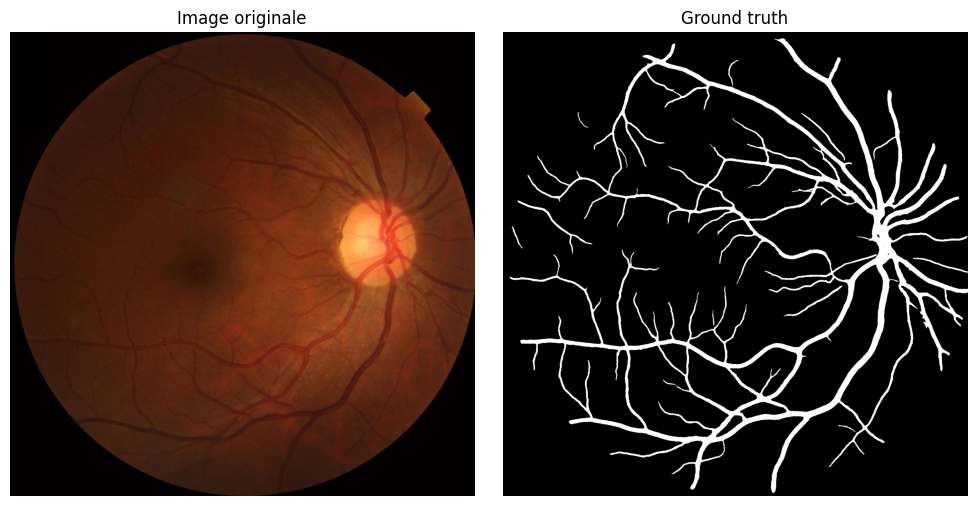

In [4]:
# Visualisation d'un exemple
num_obs = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(load_img(train_img[num_obs]))
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(load_label(train_label[num_obs]), cmap='gray')
axes[1].set_title('Ground truth')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Dataloaders

In [5]:
import torchvision.transforms as transforms
from src.dataset.dataset import VesselDataset
from torch.utils.data import DataLoader, random_split

# Paramètres depuis la config
batch_size = config['training']['batch_size']
image_size = config['data']['image_size']
train_split = config['data']['train_split']

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

dataset = VesselDataset(train_img, train_label, transform=transform)

train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset créé avec image_size={image_size}, batch_size={batch_size}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Dataset créé avec image_size=128, batch_size=8
Train: 480, Val: 120


## Modèle

In [6]:
import torch
import torch.nn as nn
from src.utils.resume_training import get_model_from_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Chargement du modèle (nouveau ou reprise d'entraînement) via la config
model = get_model_from_config(config, device)

# Hyperparamètres depuis la config
EPOCHS = config['training']['n_epochs']
LR = config['training']['learning_rate']
PATIENCE = config['training']['patience']
epsilon = config['training']['epsilon']
dir_save = config['paths']['save_dir']

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f"\nHyperparamètres:")
print(f"| Epochs: {EPOCHS}")
print(f"| Learning rate: {LR}")
print(f"| Patience: {PATIENCE}")
print(f"| Epsilon: {epsilon}")

Device: cpu
Démarrage d'un nouvel entraînement.

Hyperparamètres:
| Epochs: 3
| Learning rate: 0.0001
| Patience: 5
| Epsilon: 0.5


## Training

In [ ]:
from src.models.train import train

train_losses, val_losses = train(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    EPOCHS, 
    PATIENCE, 
    epsilon, 
    dir_save
)

 68%|██████▊   | 41/60 [02:22<01:08,  3.61s/it]

## Loss

In [ ]:
from src.utils.visualisation import viz_train_and_val_losses

viz_train_and_val_losses(train_losses, val_losses)